In [4]:
#图像直方图
def histogram(image):
    (row, col) = image.shape
    #创建长度为256的list
    hist = [0]*256
    for i in range(row):
        for j in range(col):
            hist[image[i,j]] += 1
    hist=hist/np.sum(hist)   #这里一定要用np.sum，python的列表不是直接除以一个整数
    return hist
#规定化直方图
# type=1目标直方图是正三角形， type=2倒三角形， type=3平形，
def regulation_histogram(img,type=1,mapSML=True):
    '''    
    :param img: 
    :param type: type=1目标直方图是正三角形， type=2倒三角形， type=3平形，
    :param mapSML: True是SML False是GML
    :return: 直方图和图像
    '''
    rows,cols = img.shape
    gray_flat = img.reshape((rows*cols,))

    dif = np.zeros((256,256),np.float) #用于存放原直方图与目标直方图的差
    S = np.zeros((rows,cols),np.uint8) #单映射规定化后图像
    G = np.zeros((rows,cols),np.uint8) #组映射规定化后图像
    src = np.zeros((256,),np.int32)    #原直方图
    dst = np.zeros((256,),np.int32)    #规定直方图
    H_SML = np.zeros((256,),np.int32)   #单映射的映射关系
    H_GML = np.zeros((256,), np.int32)  #组映射的映射关系
    SH = np.zeros((256,),np.float)     #单映射规定化后直方图
    GH = np.zeros((256,),np.float)    #组映射规定化后直方图

    # 计算原图像各个灰度级数量
    for index,value in enumerate(gray_flat):
        src[value] += 1

    #归一化处理
    src_pro = src/sum(src)

    # 计算灰度级的累计分布
    for i in range(1,256):
        src_pro[i] = src_pro[i - 1] + src_pro[i]

    #目标直方图为正直角三角形
    if type==1:
        for i in range(256):
            dst[i] = i
    #目标直方图为倒三角形
    if type==2:
        for i in range(256):
            dst[i] = 256-i
    #目标直方图是平行的
    if type==3:
        for i in range(256):
            dst[i] = 128

    # plt.plot(dst)
    # plt.show()
    #归一化处理
    dst_pro=dst/sum(dst)

    # 计算规定化灰度级的累计分布
    for i in range(1,256):
        dst_pro[i] = dst_pro[i - 1] + dst_pro[i]

    #|V2-V1|计算目标直方图与原直方图的差
    for i in range(256):
        for j in range(256):
            dif[i,j] = abs(src_pro[i]-dst_pro[j])

    #SML单映射
    if mapSML==True:
        for i in range(256):
            minx = 0
            minvalue = dif[i,0]
            for j in range(1,256):
                if(dif[i,j]<minvalue):
                    minvalue=dif[i,j]
                    minx=j
            H_SML[i]=minx   #将灰度i映射为灰度minx

        for i in range(256):
            SH[H_SML[i]]+= src[i]  #src[i]是灰度为i的像素个数，SH是规定化后的直方图

        SHpro = SH/sum(SH)

        for i in range(rows):
            for j in range(cols):
                S[i,j]=H_SML[img[i,j]]   #S是单映射得到的图像，将灰度值img[i,j]映射为H_SML[img[i,j]]
        return SHpro, S
    else:
        #GML群映射
        lastStartY = 0
        lastEndY = 0
        startY = 0
        endY = 0
        for i in range(256):
            minvalue = dif[0,i]
            for j in range(1,256):
                if(minvalue>dif[j,i]):
                    minvalue=dif[j,i]
                    endY=j
            if(startY != lastStartY ) or (endY != lastEndY):
                for k in range(startY,endY+1):
                    H_GML[k]=i

                lastStartY=startY
                lastEndY=endY
                startY=lastEndY+1

        for i in range(256):
            GH[H_GML[i]]+= src[i]   #组映射直方图

        for i in range(rows):
            for j in range(cols):
                G[i,j]=H_GML[img[i,j]]   #G是组映射得到的图像

        GHpro = GH/sum(GH)      #归一化直方图
        return GHpro, G
#全局线性变换
def global_linear_transmation(im,c=0,d=255):
    img=im.copy()
    maxV = img.max()
    minV = img.min()
    if maxV==minV:
        return np.uint8(img)
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            img[i, j] = ((d-c) / (maxV - minV)) * (img[i, j] - minV)+c#img[i,j]代表的是某像素点三通道的值
    return np.uint8(img)


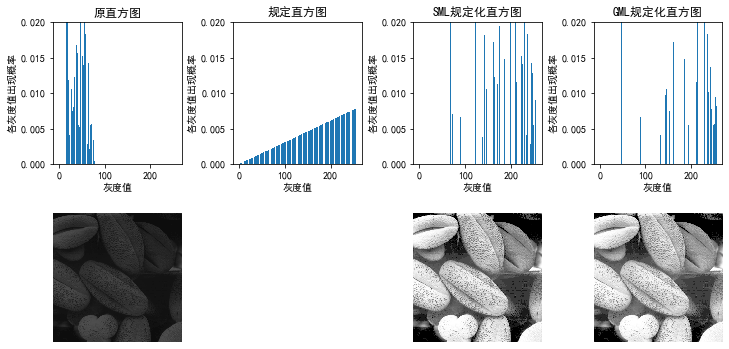

In [5]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
%config InlinBackend.figure_format="retina"
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负

img1 = cv2.imread(r'..\img\rice.tif',0)
# img1=global_linear_transmation(img0,c=50,d=200)
plt.figure(figsize=(12,6))
plt.subplots_adjust(left=None, bottom=None, right=None, \
                    top=None,wspace=0.4, hspace=0.3)

plt.subplot(241)
hist1=histogram(img1)
plt.bar(range(256),hist1)
plt.ylim(0,0.02)
plt.xlabel("灰度值")
plt.ylabel("各灰度值出现概率")
plt.title("原直方图")
dst = np.zeros((256,), np.int32)# 规定直方图
for j in range(256):
    dst[j] = j
dst=dst/np.sum(dst)
plt.subplot(242)
plt.bar(range(256),dst)
plt.ylim(0,0.02)
plt.xlabel("灰度值")
plt.ylabel("各灰度值出现概率")
plt.title("规定直方图")
histr1, equ1 = regulation_histogram(img1.copy(),1,True)
plt.subplot(243)
plt.bar(range(256),histr1)
plt.ylim(0,0.02)
plt.xlabel("灰度值")
plt.ylabel("各灰度值出现概率")
plt.title("SML规定化直方图")
histr2, equ2 = regulation_histogram(img1.copy(),1,False)
plt.subplot(244)
plt.bar(range(256),histr2)
plt.ylim(0,0.02)
plt.xlabel("灰度值")
plt.ylabel("各灰度值出现概率")
plt.title("GML规定化直方图")
plt.subplot(245)
plt.axis("off")
plt.imshow(img1,vmin=0, vmax=255,cmap =plt.cm.gray)
# plt.title("原图像", y=-0.15)
plt.subplot(247)
plt.axis("off")
plt.imshow(equ1,cmap="gray")
# plt.title("SML规定化图像", y=-0.15)
plt.subplot(248)
plt.axis("off")
plt.imshow(equ2,cmap="gray")
# plt.title("GML规定化图像", y=-0.15)
# plt.show()
plt.savefig("ch03-19_regular.jpg")
